# Evaluating mean and variance of fleet catch

## Table of Contents
- Section 0: initialization/helper functions
- Section 1: fleet catch, variance under collective quota
    - Stopping time as a function of defector proportion
- Section 2: fleet catch, variance under individual quota
    - Stopping time as a function of defector proportion
- Section 3: Archived/deprecated code 

In [1]:
%matplotlib inline

import scipy.integrate
from scipy.stats import norm
import matplotlib.pyplot as plt 
import numpy as np 
from scipy import log 
import operator


## Function definitions: find parameters of distribution of fleetwide catch for (k) days

In [4]:
# Helper functions: find the moments of lognormal distribution, given its parameters mu and sigmasqd

def find_expected(mu, sigmasqd): 
    return np.exp(mu+sigmasqd/2)

def find_variance(mu, sigmasqd): 
    return np.exp(2*mu + sigmasqd)*(np.exp(sigmasqd) - 1)


# mu_B corresponds to the special case that k = 1
def find_sigmasqd_B(k):
    num = k * np.sum( (np.exp(2*fisher_mu_B+fisher_sigma_B)) * (np.exp(fisher_sigma_B*fisher_sigma_B) - 1) )
    denom = pow(k * np.sum( np.exp(fisher_mu_B+fisher_sigma_B/2) ),2) 
    return log(num / denom + 1)

def find_mu_B(sigmasqd_B, k): 
    return log( np.sum( np.exp(2*fisher_mu_B + fisher_sigma_B*fisher_sigma_B / 2) ) ) - sigmasqd_B / 2 

sigmasqd_B = find_sigmasqd_B(1)
mu_B = find_mu_B(sigmasqd_B,1)

## Section 1
## Compute expected fleetwide catch under collective quota, assuming normal distribution 

### Using simulation parameters 


100


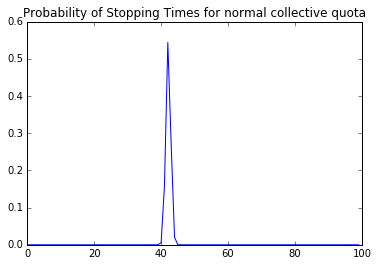

[46355696.589450315, 530309168983.31152]


In [8]:


sig = 2444
norm_fisher_mu_T = np.empty(n)
norm_fisher_sigma_T = np.empty(n)
norm_fisher_mu_B = np.empty(n)
norm_fisher_sigma_B = np.empty(n)
for i in np.arange(0,n): 
    if i < 50: 
        # cooperator catch
        norm_fisher_mu_T[i] = 10476
        norm_fisher_mu_B[i] = 8800
    else:
        norm_fisher_mu_T[i] = 11524
        norm_fisher_mu_B[i] = 13200
    
norm_fisher_sigma_T.fill(sig)

Q = 45800000 
print n
# fleetwide catch: 
# start from k = 0 
def find_fleet_catch(fisher_mu_B, fisher_sigma_B, fisher_mu_T, fisher_sigma_T):

    iterations = 100
    prob_stopping_time = np.zeros(iterations)
    
    # mu_B = single day's catch, variance
    mu_B = sum(fisher_mu_B)
#     print mu_B
    sigmasqd_B = sum(fisher_sigma_B*fisher_sigma_B)
#     print np.sqrt(sigmasqd_B)
    
    #helper function for the probability of the fleetwide catch at this time k bringing us above quota
    def integrand(q): 
        return norm.cdf(-1 * ((Q - q) - mu_B)/ np.sqrt(sigmasqd_B) ) * ( 1 / ( np.sqrt((k-1) * sigmasqd_B)*np.sqrt(2*np.pi)) ) * np.exp(-1* pow((q - (k-1)*mu_B),2)/(2*(k-1)*sigmasqd_B))
                       
    # keep track of some delta, terminate when some precision is met 
    epsilon = 0.000000001 
    k = 1
    prev = [-np.inf,-np.inf]
    result = [0,0]
    delta = np.inf
    
    #while (delta > epsilon) and (k < 10):
    while k < iterations: 
        # Find parameters of the distribution of the fleetwide catch up until time k-1
        if k == 1: 
            # probability that first catch goes above quota 
            common = 1 - norm.cdf( (Q - mu_B)/ np.sqrt(sigmasqd_B) )
        else: 
        # compute probability of the fleetwide catch at this time k bringing us above quota by integrating over possible values of F_{k-1,B}
            # common = norm.cdf( (Q - (k-1)*mu_B) / np.sqrt((k-1)*sigmasqd_B) ) * scipy.integrate.quad( integrand , 0, Q)[0]
            common = scipy.integrate.quad( integrand , 0, Q)[0]
        this = [k * mu_B * common, k * sigmasqd_B * common] 
      
        delta = max( [ abs(x) for x in map(operator.sub, this, prev) ] ) 
        prev = this
        result = map(operator.add, result, this)
        prob_stopping_time[k] = common
            
        k += 1
        # Diagnostic print statements
#         if (common > 0.3): 
#             print str(common) + " prob of stopping time when k = " + str(k)
#             print str(k) + ", this step: " + str(this) + ", result (mean, variance): " + str(result) + ", delta: " + str(delta)
    plt.plot(prob_stopping_time)
    plt.title('Probability of Stopping Times for normal collective quota')
    plt.show()

    return result



print find_fleet_catch(norm_fisher_mu_B, norm_fisher_sigma_B, norm_fisher_mu_T, norm_fisher_sigma_T)



## Stopping time as a function of defector proportion

### This code block iterates over defector proportions of the population (0%, 10%, ... 100%) and evaluates the fleet catch and variance. It will generate plots of the fleet catch and variance as a function of defector proportion. Defectors have a greater mean of species catch and bycatch. 

### Generates plots of how the probability distribution of stopping time changes as we add more defectors. 


0


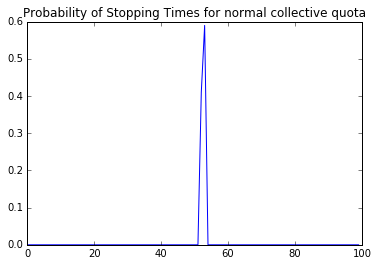

10


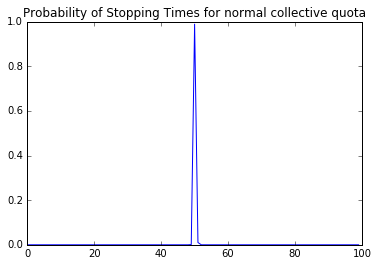

20


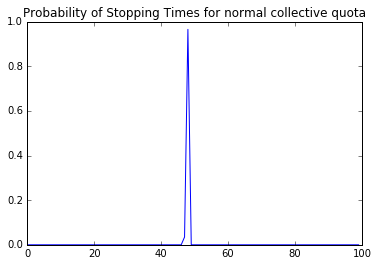

30


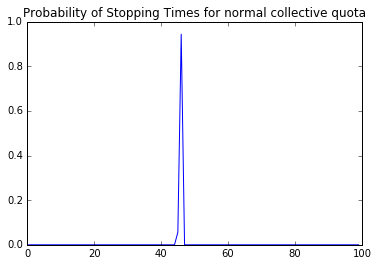

40


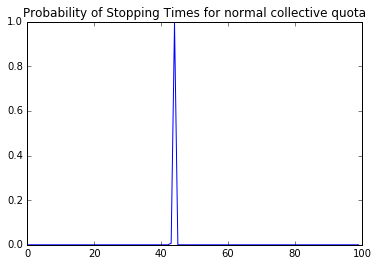

50


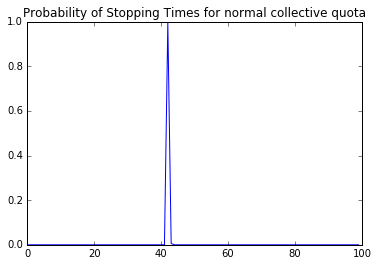

60


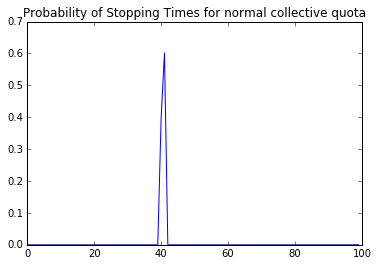

70


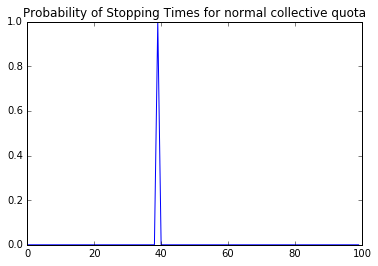

80


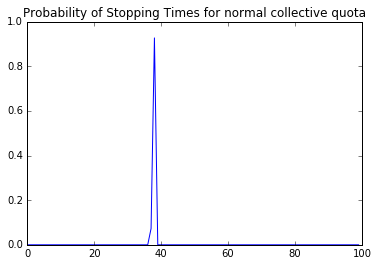

90


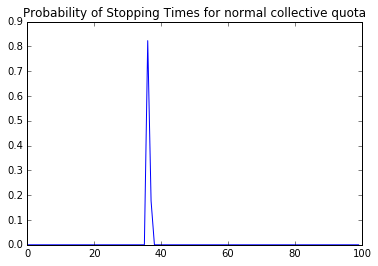

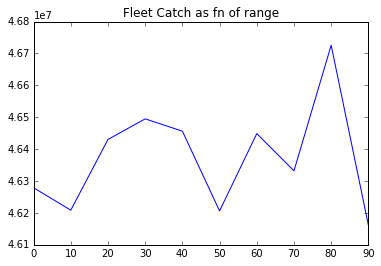

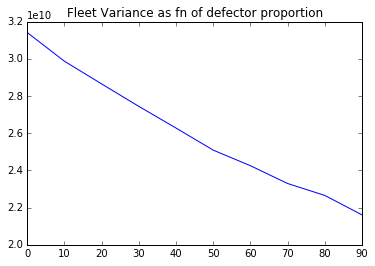

In [9]:

norm_fisher_mu_T = np.zeros(n)
norm_fisher_sigma_T = np.zeros(n)
norm_fisher_mu_B = np.zeros(n)
norm_fisher_sigma_B = np.zeros(n)

fleet_catch_norm = np.zeros(10)
fleet_var_norm = np.zeros(10)
range_prop = np.arange(0,100,10)

norm_fisher_sigma_T.fill(sig)
norm_fisher_sigma_B.fill(sig)

for ind in np.arange(0,10): 
    print range_prop[ind]
    for i in np.arange(0,range_prop[ind]): 
            # Defector catch
            norm_fisher_mu_T[i] = 11524
            norm_fisher_mu_B[i] = 13200
    for i in np.arange(range_prop[ind],n):
            # cooperator catch
            norm_fisher_mu_T[i] = 10476
            norm_fisher_mu_B[i] = 8800
            
    result = find_fleet_catch(norm_fisher_mu_B, norm_fisher_sigma_B, norm_fisher_mu_T, norm_fisher_sigma_T)
    fleet_catch_norm[ind] = result[0]
    fleet_var_norm[ind] = result[1]


    
plt.plot(range_prop,fleet_catch_norm)
plt.title('Fleet Catch as fn of range')
plt.show()

plt.plot(range_prop, fleet_var_norm)
plt.title('Fleet Variance as fn of defector proportion')
plt.show()

In [ ]:
def integrand(q): 
    return norm.cdf(-1 * ((Q - q) - mu_B)/ np.sqrt(sigmasqd_B) ) * ( 1 / ( np.sqrt((k-1) * sigmasqd_B)*np.sqrt(2*np.pi)) ) * np.exp(-1* pow((q - (k-1)*mu_B),2)/(2*(k-1)*sigmasqd_B))
                    

# Section 2
## Find fleet catch mean, variance under individual quota: assuming normal distribution


0
100, this step: [4.427404154721494e-55, 3.0051689935359683e-52], result (mean, variance): [46274445.325136222, 31409494914.95488], delta: 3.08598065859e-50


C:\Users\paint_000\Anaconda\lib\site-packages\IPython\kernel\__main__.py:26: RuntimeWarning: overflow encountered in exp
C:\Users\paint_000\Anaconda\lib\site-packages\IPython\kernel\__main__.py:27: RuntimeWarning: overflow encountered in exp


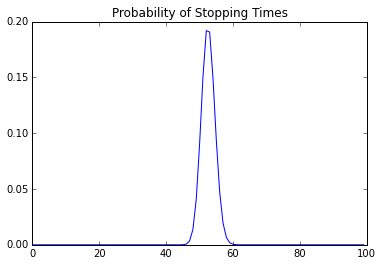

10
100, this step: [3.9846637392493443e-55, 2.7046520941823713e-52], result (mean, variance): [46295263.35347867, 30371932123.436783], delta: 2.77738259273e-50


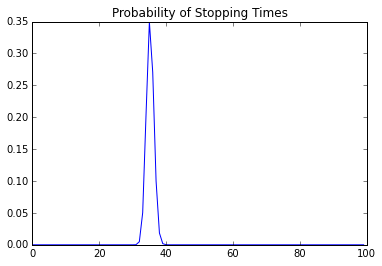

20
100, this step: [3.5419233237771955e-55, 2.4041351948287744e-52], result (mean, variance): [46316081.381821156, 29334369331.918697], delta: 2.46878452687e-50


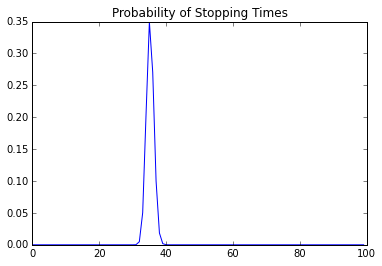

30
100, this step: [3.0991829083050458e-55, 2.1036182954751774e-52], result (mean, variance): [46336899.410163641, 28296806540.400627], delta: 2.16018646101e-50


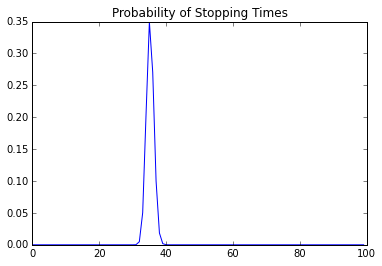

40
100, this step: [2.6564424928328966e-55, 1.8031013961215805e-52], result (mean, variance): [46357717.438506067, 27259243748.882534], delta: 1.85158839515e-50


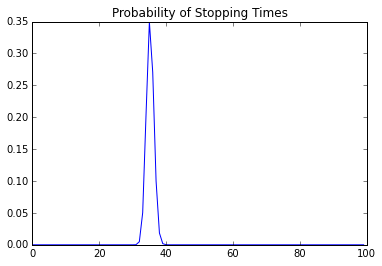

50
100, this step: [2.2137020773607473e-55, 1.5025844967679845e-52], result (mean, variance): [46378535.466848537, 26221680957.364445], delta: 1.54299032929e-50


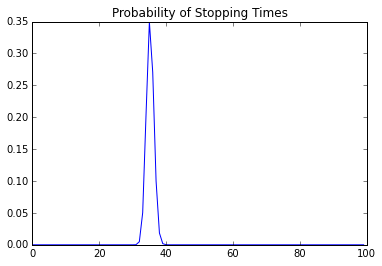

60
100, this step: [1.7709616618885977e-55, 1.2020675974143876e-52], result (mean, variance): [46399353.495191015, 25184118165.846348], delta: 1.23439226343e-50


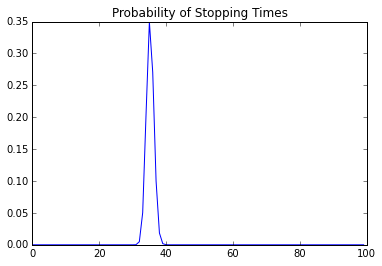

70
100, this step: [1.3282212464164478e-55, 9.0155069806079063e-53], result (mean, variance): [46420171.523533471, 24146555374.328262], delta: 9.25794197576e-51


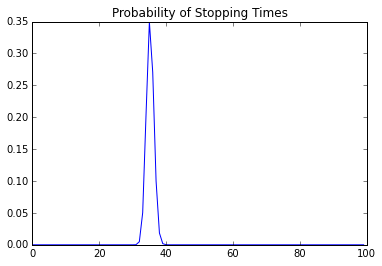

80
100, this step: [8.8548083094429868e-56, 6.0103379870719378e-53], result (mean, variance): [46440989.551875919, 23108992582.810177], delta: 6.17196131717e-51


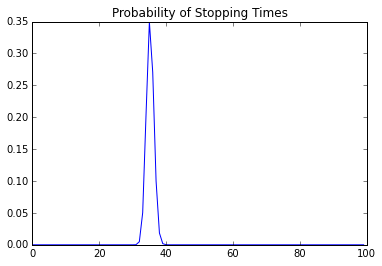

90
100, this step: [4.4274041547214934e-56, 3.0051689935359689e-53], result (mean, variance): [46461807.580218382, 22071429791.292088], delta: 3.08598065859e-51


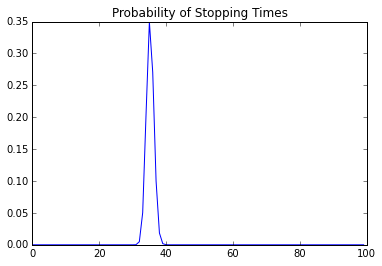

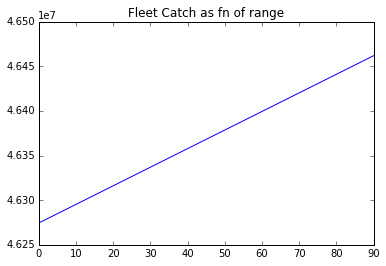

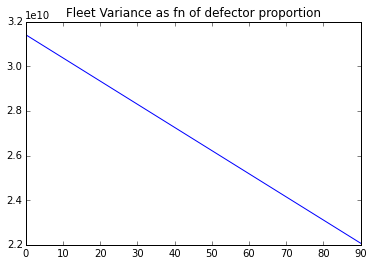

In [11]:
# find fleet catch and variance for individual quotas
def find_fleet_catch_IBQ(fisher_mu_B, fisher_sigma_B, fisher_mu_T, fisher_sigma_T, IBQ, dist):
    iterations = 100
    prob_stopping_time = np.zeros((n, iterations))
    
    def integrand(q, ibq, k, mu, sigma): 
        return norm.cdf(-1 * ((ibq - q) - mu)/ (sigma) ) * ( 1 / ( np.sqrt((k-1)) * sigma * np.sqrt(2*np.pi)) ) * np.exp(-1* pow((q - (k-1)*mu),2)/(2*(k-1)*sigma*sigma))
    def log_n_integrand(q, ibq, k ): 
        # need to use pearson type IV 
        # return () * ( 1 / q *  np.sqrt(k-1) * sigma * np.sqrt(2*np.pi) ) * np.exp(-1* pow((log(ibq) - q,2)/(2*(k-1)*sigma*sigma)))
        return
    def compute_integral(ibq, dist, i):
        if dist == "normal":
            return scipy.integrate.quad( integrand , 0, ibq, args=(ibq, k, fisher_mu_B[i], fisher_sigma_B[i]))[0]
        elif dist == "lognormal": 
            return scipy.integrate.quad( log_n_integrand, 0, ibq, args=(ibq, k, fisher_mu_B[i], fisher_sigma_B[i]))[0]
        
    # keep track of some delta, terminate when some precision is met 
    epsilon = 0.000000001 
    k = 2
    prev = [-np.inf,-np.inf]
    result = [0,0]
    delta = np.inf
    while (k < iterations):
        # deprecated: compute parameters of lognormal distribution 
#         log_n_catch = np.exp(fisher_mu_T+fisher_sigma_T*fisher_sigma_T/2) 
#         log_n_var = np.exp(2*fisher_mu_T + fisher_sigma_T*fisher_sigma_T) * (np.exp(fisher_sigma_T) - 1) 
        
        # compute this iteration with k 
        # ~FIXME this hack uses the simplification that all fishers have same IBQ; not great for generalizability
        common = np.empty(len(IBQ))
        for i in range(len(IBQ)):
            common[i] = compute_integral( IBQ[i], "normal", i )
            prob_stopping_time[i, k] = common[i]
        if dist == "normal": 
            this = [ np.sum( k * fisher_mu_B * common ), np.sum(k * (fisher_sigma_B * fisher_sigma_B) * common) ] 
        elif dist == "lognormal": 
            this = [ np.sum( k * log_n_catch * common ), np.sum(k * log_n_var * common) ]                                                                   
                                                                                                                            
        delta = max( [ abs(x) for x in map(operator.sub, this, prev) ] ) 
        prev = this
        result = map(operator.add, result, this)
        
        k += 1

        if (k % 100 == 0): 
            print str(k) + ", this step: " + str(this) + ", result (mean, variance): " + str(result) + ", delta: " + str(delta)
        
        
    plt.plot(prob_stopping_time[1,])
    plt.title('Probability of Stopping Times')
    plt.show()
    return result

def initialize_and_compute(n_defector): 

    sig = 2444
    norm_fisher_mu_T = np.zeros(n)
    norm_fisher_sigma_T = np.zeros(n)
    norm_fisher_mu_B = np.zeros(n)
    norm_fisher_sigma_B = np.zeros(n)
    for i in np.arange(0,n_defector):  
            norm_fisher_mu_T[i] = 11524
            norm_fisher_mu_B[i] = 13200
    for i in np.arange(n_defector,n):
                        # cooperator catch
            norm_fisher_mu_T[i] = 10476
            norm_fisher_mu_B[i] = 8800

    norm_fisher_sigma_T.fill(sig)
    norm_fisher_sigma_B.fill(sig)

    IBQ = np.empty(n) 
    IBQ.fill(Q / n)
    return find_fleet_catch_IBQ(norm_fisher_mu_B, norm_fisher_sigma_B, norm_fisher_mu_T, norm_fisher_sigma_T, IBQ, "normal")

def generate_fleet_performance_fn_defectors():
    fleet_catch = np.zeros(10)
    fleet_var = np.zeros(10)
    range_prop = np.arange(0,100,10)
    for ind in np.arange(0,10): 
        print range_prop[ind]
        result = initialize_and_compute(range_prop[ind], n)
        fleet_catch[ind] = result[0]
        fleet_var[ind] = result[1]
    
    plt.plot(fleet_catch, range_prop)
    plt.plot(fleet_var, range_prop)
    plt.title('Fleet Catch and Variance as fn of range')
    plt.show()
    return
    
n = 100
# generate_fleet_performance_fn_defectors()
norm_fisher_mu_T = np.zeros(n)
norm_fisher_sigma_T = np.zeros(n)
norm_fisher_mu_B = np.zeros(n)
norm_fisher_sigma_B = np.zeros(n)

fleet_catch = np.zeros(10)
fleet_var = np.zeros(10)
range_prop = np.arange(0,100,10)

norm_fisher_sigma_T.fill(sig)
norm_fisher_sigma_B.fill(sig)

for ind in np.arange(0,10): 
    print range_prop[ind]
    for i in np.arange(0,range_prop[ind]):  
            norm_fisher_mu_T[i] = 11524
            norm_fisher_mu_B[i] = 13200
    for i in np.arange(range_prop[ind],n):
                        # cooperator catch
            norm_fisher_mu_T[i] = 10476
            norm_fisher_mu_B[i] = 8800
            
    result = find_fleet_catch_IBQ(norm_fisher_mu_B, norm_fisher_sigma_B, norm_fisher_mu_T, norm_fisher_sigma_T, IBQ, "normal")
    fleet_catch[ind] = result[0]
    fleet_var[ind] = result[1]
    
plt.plot(range_prop,fleet_catch)
plt.title('Fleet Catch as fn of range')
plt.show()

plt.plot(range_prop, fleet_var)
plt.title('Fleet Variance as fn of defector proportion')
plt.show()

## Individual Bycatch Quota: Fleet Catch and Variance as a function of defector proportion

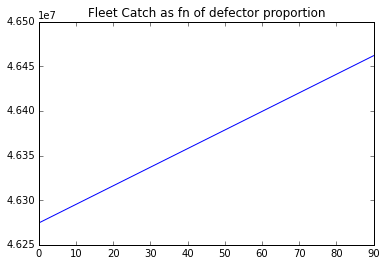

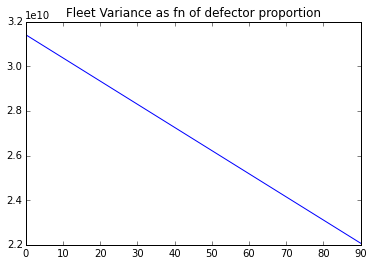

In [12]:
plt.plot(range_prop,fleet_catch)
plt.title('Fleet Catch as fn of defector proportion')
plt.show()

plt.plot(range_prop, fleet_var)
plt.title('Fleet Variance as fn of defector proportion')
plt.show()

# Section 3
# Archive

## Archived: Old: Find fleet catch mean, variance under collective quota 

Numerically approximates the discrete expectation over stopping time k to compute: 


\begin{equation}
E[F_{T}] = \sum_k^{\infty}k (\sum_{i=1}^n e^{\mu_{i,T} + \frac{\sigma_i^2}{2} } )   \Phi \left[ \frac{log Q - \mu_{Z,B}}{\sigma_{Z,B}} \right]  \int_0^Q \Phi \left[ -\frac{log(Q-q)-\mu_B}{\sigma_B} \right] \frac{1}{q \sigma_{Z,B} \sqrt{2 \pi}} exp \left[ - \frac{(log (q)- \mu_{Z,B})^2}{2 \sigma_{Z,B}^2}  \right] dq 
\end{equation} 

\begin{align}
 Var[F_{T}] =  \sum_k^{\infty} k \sum_{i=1}^n e^{2 \mu_{i,T} + \sigma_{i,T}^2} (e^{\sigma_i^2} -1)   \Phi \left[ \frac{log Q - \mu_{Z,B}}{\sigma_{Z,B}} \right]  \int_0^Q \Phi \left[ -\frac{log(Q-q)-\mu_B}{\sigma_B} \right] \frac{1}{q \sigma_{Z,B} \sqrt{2 \pi}} exp \left[ - \frac{(log (q)- \mu_{Z,B})^2}{2 \sigma_{Z,B}^2}  \right] dq 
\end{align} 

In [ ]:
Q = 45800000 

# fleetwide catch: 
# start from k = 0 
def find_fleet_catch(fisher_mu_B, fisher_sigma_B, mu_B, sigmasqd_B, fisher_mu_T, fisher_sigma_T):
    
    # approximate the cumulative CDF for sum of lognormals following
    # https://etd.ohiolink.edu/!etd.send_file?accession=wright1229358144&disposition=inline
    #                                                                                                                                                                            

    #helper function for the probability of the fleetwide catch at this time k bringing us above quota
    def integrand(q): 
        return norm.cdf(-1 * (log(Q - q) - mu_B)/ np.sqrt(sigmasqd_B) ) * (1/ (q * np.sqrt(sigmasqd_Z_B)*np.sqrt(2*np.pi))) * np.exp(-1* pow((log(q) - mu_Z_B),2)/(2*sigmasqd_Z_B))
                       
    # keep track of some delta, terminate when some precision is met 
    epsilon = 0.000000001 
    k = 1
    prev = [-np.inf,-np.inf]
    result = [0,0]
    delta = np.inf
    
    single_catch = np.sum( find_expected(fisher_mu_T, fisher_sigma_T*fisher_sigma_T) )
    single_var = np.sum( find_variance(fisher_mu_T, fisher_sigma_T*fisher_sigma_T) ) 
    while (k < 1000):
        # Find parameters of the distribution of the fleetwide catch up until time k-1
        if k == 1: 
            sigmasqd_Z_B = find_sigmasqd_B(1)
            mu_Z_B = find_mu_B(sigmasqd_Z_B, 1)
            # probability that first catch goes above quota 
            common = 1 - norm.cdf( (log(Q) - mu_Z_B)/ np.sqrt(sigmasqd_Z_B) )
            print str(common) + " prob of stopping time when k = 1"
        else: 
            sigmasqd_Z_B = find_sigmasqd_B(k-1)
            mu_Z_B = find_mu_B(sigmasqd_Z_B, k-1)
        
            print(mu_Z_B)
            print(sigmasqd_Z_B)
        
            print find_expected(mu_Z_B, sigmasqd_Z_B)
            print find_variance(mu_Z_B, sigmasqd_Z_B)
        # compute probability of the fleetwide catch at this time k bringing us above quota by integrating over possible values of F_{k-1,B}
            common = scipy.integrate.quad( integrand , 0, Q)[0]
        
        this = [k * single_catch * common, k * single_var * common] 
        
        print scipy.integrate.quad( integrand , 0, Q)
        
        delta = max( [ abs(x) for x in map(operator.sub, this, prev) ] ) 
        prev = this
        result = map(operator.add, result, this)
        print "________________________________"
        k += 1
        if (k % 100 == 0): 
            print str(k) + ", this step: " + str(this) + ", result (mean, variance): " + str(result) + ", delta: " + str(delta)
        
    return result

find_fleet_catch(fisher_mu_B, fisher_sigma_B, mu_B, sigmasqd_B, fisher_mu_T, fisher_sigma_T)

In [ ]:
# Archived: Pearson approximation for lognormal 
def pdf_type_IV(x, moments): 
        
    M_P = moments['M1']
    V_P = moments['M2']
    SK_P = moments['M3']
    KU_P = moments['M4']
    r = 6*(KU_P - SK_P*SK_P - 1) / (2*KU_P - 3*SK_P*SK_P - 6) 
    
    def integrand(x): 
        return pow(np.cos(x), r) * np.exp(-1 * mu_2 * x) 
    
    mu_1 = (r + 2) / 2
    mu_2 = (-r * (r - 2) * SK_P) / np.sqrt( 16 * (r - 1) - SK_P*SK_P*(r - 2)*(r - 2) )
    mu_3 = np.sqrt(V_P * (r - 1 - SK_P*SK_P*(r - 2)*(r - 2)/16 ) )
    mu_4 = M_P - (r - 2) * SK_P * np.sqrt(V_P) / 4
    nu = mu_3 / scipy.integrate.quad( integrand , -1 * np.pi/2, np.pi/2 )
    
    return nu * pow(1 + (x - mu_4)*(x - mu_4) / mu_3 * mu_3, -mu_1 ) * np.exp(-mu_2 * np.arctan( (x - mu_4)/mu_3 ))
    
    
def approx_logn_cdf(fisher_mu, fisher_sigma): 
    moments = {}
    a = np.exp(fisher_mu)
    b = np.exp(fisher_sigma*fisher_sigma)
    moments['M1'] = sum(a*np.sqrt(b))
    moments['M2'] = sum(a*a*b*(b-1))
    moments['M3'] = sum(pow(a,3)*pow(b,1.5)*(b-1)*(b-1)*(b+2))
    # how to do a double sum in python?? 
    moments['M4'] = sum(pow(a,4)*b*b*(b-1)*(b-1)*(pow(b,4)+2*pow(b,3)+3*b*b - 3)) 
    for i in arange(0,len(a)): 
        for j in arange(i, len(a)): 
            moments['M4'] += 6 * a[i]*a[i]*b[i]*(b[i] - 1)*a[j]*a[j]*b[j]*(b[j] - 1)
    return moments